<a href="https://colab.research.google.com/github/yjchen9596/tensorflow-for-deep-learning/blob/main/l08c07_forecasting_with_stateful_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a stateful RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c07_forecasting_with_stateful_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c07_forecasting_with_stateful_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

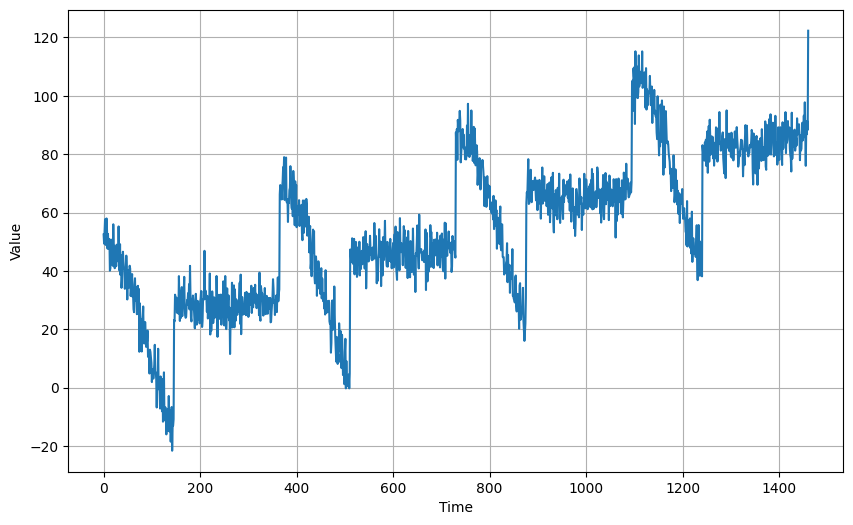

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Stateful RNN Forecasting

In [16]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(1).prefetch(1)

In [7]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [8]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [18]:
window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    # accept any length (None) in the time dimension
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=(None, 1)),
    keras.layers.SimpleRNN(100),              # defaults to stateful=False
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

model.compile(
    loss=keras.losses.Huber(),
    optimizer=keras.optimizers.SGD(1e-7, momentum=0.9),
    metrics=["mae"]
)

history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=500,
    callbacks=[
      keras.callbacks.EarlyStopping(patience=50),
      keras.callbacks.ModelCheckpoint("ckpt.h5", save_best_only=True)
    ]
)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


     29/Unknown 3s 12ms/step - loss: 115.0447 - mae: 115.5445

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 108.9125 - mae: 109.4122 - val_loss: 36.2022 - val_mae: 36.7022
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 27.8404 - mae: 28.3370

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 27.6047 - mae: 28.1012 - val_loss: 9.6554 - val_mae: 10.1455
Epoch 3/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 21.3003 - mae: 21.7950

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 20.9222 - mae: 21.4168 - val_loss: 6.9886 - val_mae: 7.4758
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.4250 - mae: 18.9141

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 18.3338 - mae: 18.8229 - val_loss: 6.6593 - val_mae: 7.1455
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 16.5022 - mae: 16.9918 - val_loss: 7.1067 - val_mae: 7.5949
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15.0144 - mae: 15.5046 - val_loss: 7.1884 - val_mae: 7.6758
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 13.8089 - mae: 14.2969 - val_loss: 7.2545 - val_mae: 7.7423
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 12.6477 - mae: 13.1358 - val_loss: 7.4980 - val_mae: 7.9842
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 11.6385 - mae: 12.1248 - val_loss: 7.9184 - val_mae: 8.4099
Epoch 10/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 10.6506 - mae: 11.1355 - val_loss: 8.4547 - val_mae: 8.9466
Epoch 11/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.7235 - mae: 10.2088 - val_loss: 8.6889 - val_mae: 9.1810
Epoch 12/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/ste

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.0858 - mae: 5.5690 - val_loss: 6.6185 - val_mae: 7.1027
Epoch 37/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9904 - mae: 5.4733

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.0611 - mae: 5.5441 - val_loss: 6.5412 - val_mae: 7.0256
Epoch 38/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9356 - mae: 5.4176

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.0358 - mae: 5.5179 - val_loss: 6.4717 - val_mae: 6.9567
Epoch 39/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9111 - mae: 5.3928

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.0110 - mae: 5.4928 - val_loss: 6.4172 - val_mae: 6.9024
Epoch 40/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9620 - mae: 5.4424

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.9836 - mae: 5.4641 - val_loss: 6.3710 - val_mae: 6.8560
Epoch 41/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8579 - mae: 5.3353

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.9570 - mae: 5.4349 - val_loss: 6.3345 - val_mae: 6.8182
Epoch 42/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7979 - mae: 5.2721

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.9285 - mae: 5.4034 - val_loss: 6.2978 - val_mae: 6.7808
Epoch 43/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8289 - mae: 5.3013

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.8988 - mae: 5.3717 - val_loss: 6.2611 - val_mae: 6.7447
Epoch 44/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7994 - mae: 5.2724

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.8690 - mae: 5.3424 - val_loss: 6.2309 - val_mae: 6.7150
Epoch 45/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7448 - mae: 5.2168

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.8425 - mae: 5.3150 - val_loss: 6.2021 - val_mae: 6.6861
Epoch 46/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7519 - mae: 5.2207

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.8204 - mae: 5.2896 - val_loss: 6.1801 - val_mae: 6.6641
Epoch 47/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7804 - mae: 5.2458

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.8010 - mae: 5.2666 - val_loss: 6.1754 - val_mae: 6.6602
Epoch 48/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7886 - mae: 5.2567 - val_loss: 6.1801 - val_mae: 6.6647
Epoch 49/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7834 - mae: 5.2541 - val_loss: 6.1866 - val_mae: 6.6715
Epoch 50/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7800 - mae: 5.2531 - val_loss: 6.1962 - val_mae: 6.6811
Epoch 51/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.7783 - mae: 5.2531 - val_loss: 6.1907 - val_mae: 6.6759
Epoch 52/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.7778 - mae: 5.2528 - val_loss: 6.1754 - val_mae: 6.6608
Epoch 53/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.7596 - mae: 5.2340

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.7775 - mae: 5.2520 - val_loss: 6.1629 - val_mae: 6.6483
Epoch 54/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7202 - mae: 5.1940

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.7778 - mae: 5.2517 - val_loss: 6.1544 - val_mae: 6.6400
Epoch 55/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7220 - mae: 5.1950

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7784 - mae: 5.2516 - val_loss: 6.1472 - val_mae: 6.6325
Epoch 56/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7008 - mae: 5.1728

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7797 - mae: 5.2519 - val_loss: 6.1390 - val_mae: 6.6240
Epoch 57/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7045 - mae: 5.1753

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.7818 - mae: 5.2530 - val_loss: 6.1305 - val_mae: 6.6149
Epoch 58/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6855 - mae: 5.1548

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.7854 - mae: 5.2554 - val_loss: 6.1259 - val_mae: 6.6093
Epoch 59/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7170 - mae: 5.1868

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7906 - mae: 5.2609 - val_loss: 6.1252 - val_mae: 6.6078
Epoch 60/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.7973 - mae: 5.2670 - val_loss: 6.1295 - val_mae: 6.6115
Epoch 61/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.8052 - mae: 5.2745 - val_loss: 6.1372 - val_mae: 6.6190
Epoch 62/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.8135 - mae: 5.2832 - val_loss: 6.1470 - val_mae: 6.6283
Epoch 63/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.8213 - mae: 5.2913 - val_loss: 6.1522 - val_mae: 6.6335
Epoch 64/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.8283 - mae: 5.2984 - val_loss: 6.1582 - val_mae: 6.6392
Epoch 65/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.8365 - mae: 5.3071 - val_loss: 6.1720 - val_mae: 6.6525
Epoch 66/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.8440 - mae: 5.3148 - val_loss: 6.1805 - val_mae: 6.6605
Epoch 67/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 

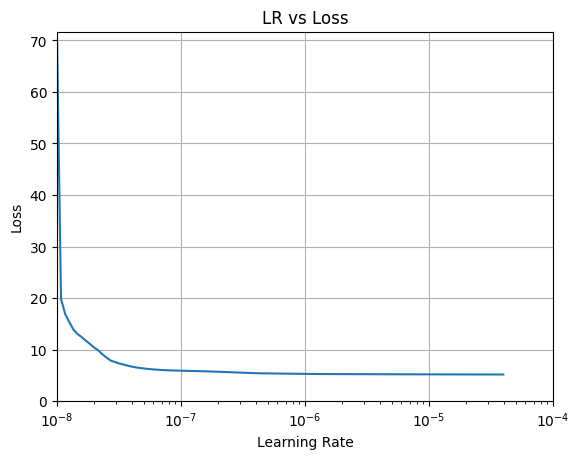

In [23]:
losses = history.history["loss"]
epochs = len(losses)
lrs    = 1e-8 * (10 ** (np.arange(epochs) / 30))

plt.semilogx(lrs, losses)
plt.axis([1e-8, 1e-4, 0, max(losses)])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("LR vs Loss")
plt.grid(True)
plt.show()

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [ ]:
rnn_forecast.shape

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()